### Edgar Moises Hernandez-Gonzalez
#### 08/07/19-06/02/20
#### Clasificar habla imaginada en EEG con CNN y LSTM (TimeDistributed), con CV=5

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, Dropout, MaxPool1D, Flatten, LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [0]:
datos = pd.read_csv("/content/drive/My Drive/HablaImaginadaDL/Submuestreo01.csv", header=None)
x = datos.iloc[:, 0:3072].values
y = datos.iloc[:, 3072].values

In [0]:
print(x.shape)
print(y.shape)

(132, 3072)
(132,)


In [0]:
n_samples = len(y)
print("n_samples:", n_samples)

n_samples: 132


In [0]:
n_classes = len(np.unique(y))
print("n_classes:", n_classes)

n_classes: 6


In [0]:
#escalar los datos para que tengan media = 0 y desviacion estandar = 1
x = StandardScaler().fit_transform(x)

In [0]:
#convertir de 2D a 4D
x = x.reshape((n_samples, 1, 6, 512))
print(x.shape)

(132, 1, 6, 512)


In [0]:
x = np.transpose(x, (0,1,3,2))
print(x.shape)

(132, 1, 512, 6)


In [0]:
skf = StratifiedKFold(n_splits = 5)


Iteracion: 1
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
confusion matrix:
 [[0 1 0 0 3 0]
 [0 3 0 0 3 0]
 [1 1 0 0 3 0]
 [0 1 0 0 2 0]
 [0 3 0 0 2 0]
 [0 1 0 0 1 2]]


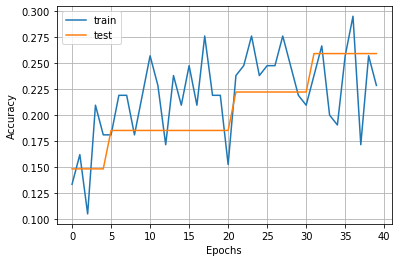

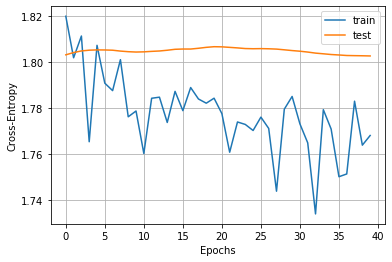

27/27 - 0s - loss: 1.8027 - acc: 0.2593

Iteracion: 2
confusion matrix:
 [[1 1 0 0 0 2]
 [2 1 2 0 0 1]
 [0 0 2 1 0 2]
 [0 0 0 1 0 2]
 [0 1 0 0 0 4]
 [0 2 1 0 0 1]]


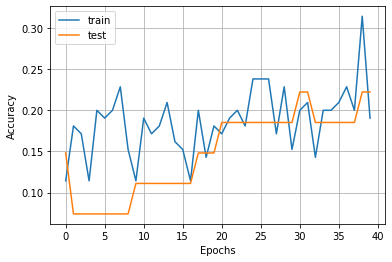

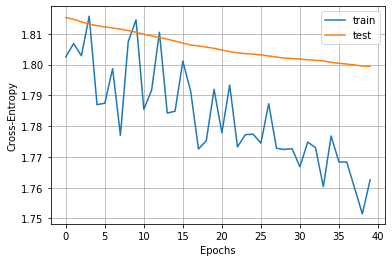

27/27 - 0s - loss: 1.7995 - acc: 0.2222

Iteracion: 3
confusion matrix:
 [[1 1 0 0 0 2]
 [3 0 1 0 0 1]
 [0 0 1 0 3 0]
 [1 0 1 0 1 0]
 [4 0 1 0 0 0]
 [1 0 2 0 1 1]]


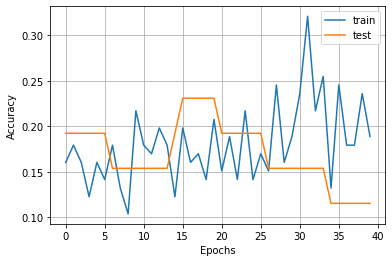

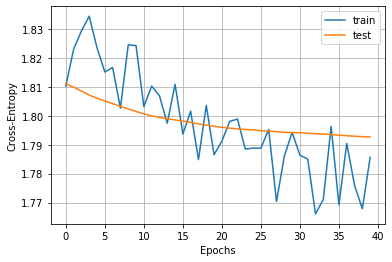

26/26 - 0s - loss: 1.7927 - acc: 0.1154

Iteracion: 4
confusion matrix:
 [[0 4 0 0 0 1]
 [0 5 0 0 0 0]
 [0 2 0 0 0 2]
 [0 2 0 0 0 1]
 [0 5 0 0 0 0]
 [0 1 1 0 0 2]]


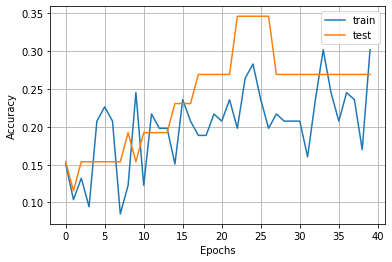

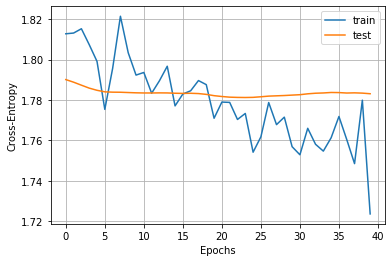

26/26 - 0s - loss: 1.7831 - acc: 0.2692

Iteracion: 5
confusion matrix:
 [[2 0 0 0 2 0]
 [2 3 0 0 0 1]
 [1 2 0 0 1 0]
 [0 2 0 0 1 0]
 [1 3 0 0 1 0]
 [2 1 0 0 1 0]]


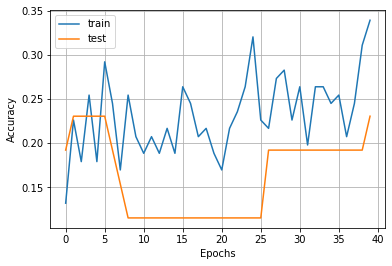

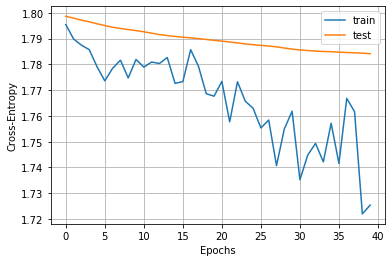

26/26 - 0s - loss: 1.7841 - acc: 0.2308


In [0]:
resultados = np.zeros((2, 5)) #accuracy y loss en cada validacion cruzada
i = 0
for iTrain, jTest in skf.split(x, y):
    print("\nIteracion:", i + 1)
    x_train, x_test = x[iTrain], x[jTest]
    y_train, y_test = y[iTrain], y[jTest]
    
    model = Sequential()
    model.add(TimeDistributed(Conv1D(4, 3, activation='relu'), input_shape=(None,512,6)))
    model.add(TimeDistributed(Conv1D(4, 3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPool1D(2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(16))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    optimizer = Adam(lr=1e-4)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, epochs=40, batch_size=64,
                        validation_data=(x_test, y_test), verbose=0)

    probabilidades = model.predict(x_test)
    y_pred = np.argmax(probabilidades, 1) #1=fila
    matriz_confusion = confusion_matrix(y_test, y_pred)
    print("confusion matrix:\n", matriz_confusion)

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'])
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy')
    plt.legend(['train', 'test'])
    plt.show()
    
    resultados[0, i], resultados[1, i] = model.evaluate(x_test, y_test, verbose=2)
    i += 1

In [0]:
print("loss:", resultados[0])
print("accuracy:", resultados[1])
print("mean accuracy:", resultados[1].mean())

loss: [1.80273294 1.79945147 1.79265022 1.78307402 1.78411269]
accuracy: [0.25925925 0.22222222 0.11538462 0.26923078 0.23076923]
mean accuracy: 0.21937322169542312


In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_20 (TimeDis (None, None, 510, 4)      76        
_________________________________________________________________
time_distributed_21 (TimeDis (None, None, 508, 4)      52        
_________________________________________________________________
time_distributed_22 (TimeDis (None, None, 508, 4)      0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, None, 254, 4)      0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, None, 1016)        0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                66112     
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)               